<a href="https://colab.research.google.com/github/VShariya/Gastrointestinal-Disease-Detection/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Gastrointestinal Disease Detection**

#Librabries

In [ ]:
from IPython import get_ipython
from IPython.display import display

In [ ]:
!pip install lightning-utilities
!pip install torchmetrics --no-deps
!pip install torchinfo --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 19.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

from timm import create_model
from torchmetrics import MeanMetric, Accuracy, ConfusionMatrix, Precision, Recall, F1Score
from torchinfo import summary
from sklearn.metrics import matthews_corrcoef

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = "cuda" if torch.cuda.is_available() \
          else "mps" if torch.mps.is_available() \
          else "cpu"

print("Device:", device)

Device: cuda


#Dataset

In [ ]:
!unzip "/content/drive/MyDrive/DL_Assignment/GDC.zip" -d KVASIR

Archive:  /content/drive/MyDrive/DL_Assignment/GDC.zip
  inflating: KVASIR/kvasir-dataset/dyed-lifted-polyps/0053d7cd-549c-48cd-b370-b4ad64a8098a.jpg  
  inflating: KVASIR/kvasir-dataset/dyed-lifted-polyps/007d5aa7-7289-4bad-aa4a-5c3a259e9b19.jpg  
  inflating: KVASIR/kvasir-dataset/dyed-lifted-polyps/00cf9508-6ad1-4db9-840a-519c1d515c30.jpg  
  inflating: KVASIR/kvasir-dataset/dyed-lifted-polyps/01507fbd-4d38-4525-9768-7754710f507c.jpg  
  inflating: KVASIR/kvasir-dataset/dyed-lifted-polyps/018ed8ed-e489-4bbb-8a99-3346db9ec160.jpg  
  inflating: KVASIR/kvasir-dataset/dyed-lifted-polyps/0195c5a6-5ddf-471c-9868-2ea66b81f440.jpg  
  inflating: KVASIR/kvasir-dataset/dyed-lifted-polyps/01d38b8f-74b2-4147-9519-448d05bf8745.jpg  
  inflating: KVASIR/kvasir-dataset/dyed-lifted-polyps/02c10865-9d23-4f6b-aa5d-f73b63b6d67f.jpg  
  inflating: KVASIR/kvasir-dataset/dyed-lifted-polyps/031a6e89-d3b7-48c8-8e2f-db991030f959.jpg  
  inflating: KVASIR/kvasir-dataset/dyed-lifted-polyps/03a49a2e-c8d4-4dcd

In [ ]:
dataset_dir = "/content/KVASIR/kvasir-dataset"

In [ ]:
# Load Dataset
dataset = ImageFolder(dataset_dir, transform=transform)
classes = dataset.classes

In [ ]:
classes

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

In [ ]:
num_classes = len(dataset.classes)
num_classes

8

## Data Transformation

In [ ]:
img_size = 224
transform = v2.Compose([
    v2.Resize((img_size, img_size)),
    # Denoise
    v2.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 2.0)),
    # Augment
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    # To Tensor & Normalize
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
# Dataset Split
indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.66, random_state=42)

In [ ]:
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

In [ ]:
print("number of train samples:", len(train_dataset))
print("number of val samples:", len(val_dataset))
print("number of test samples:", len(test_dataset))

number of train samples: 2800
number of val samples: 408
number of test samples: 792


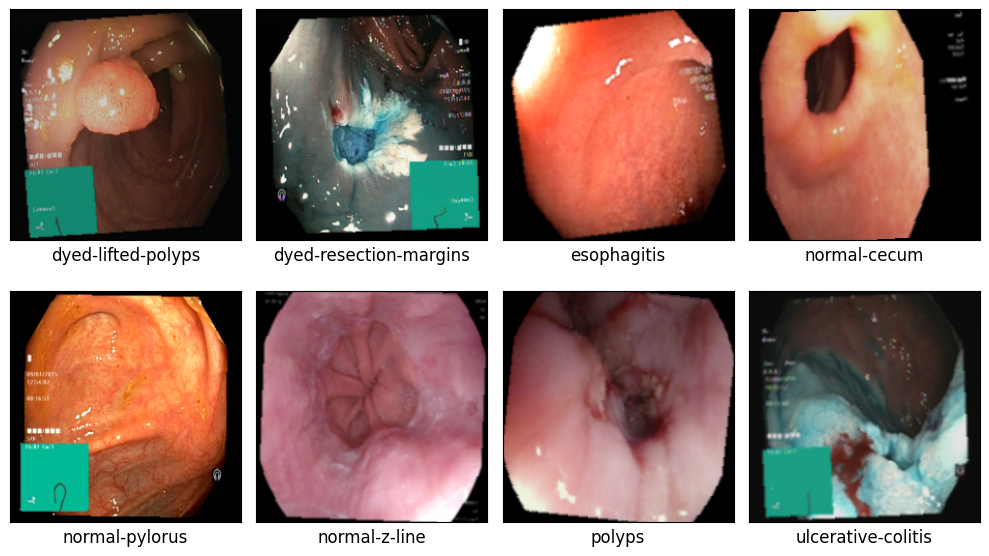

In [ ]:
# function: Visualize training image for each class
def visualize_data(dataset, classes):
  sample_images = []
  # Access the original dataset if it's a Subset
  if isinstance(dataset, Subset):
      original_dataset = dataset.dataset
      indices = dataset.indices
  else:
      original_dataset = dataset
      indices = range(len(dataset))

  # Find one image per class from the original dataset using subset indices
  found_classes = set()
  for idx in indices:
      # Access the sample from the original dataset by index
      image_tensor, label = original_dataset[idx]
      if label not in found_classes:
          # The dataset is already transformed to a tensor
          image = denormalize(image_tensor)  # denormalize
          # convert back to PIL image format
          image = to_pil_image(image.clamp(0, 1))
          sample_images.append(image)
          found_classes.add(label)
          if len(found_classes) == len(classes):
              break # Stop after finding one image per class

  # Show images in a 2x4 grid
  fig, axes = plt.subplots(2, 4, figsize=(10, 6))
  for i, axis in enumerate(axes.flat):
    axis.set_xticks([])
    axis.set_yticks([])
    # Ensure we have an image for this class before attempting to display
    if i < len(sample_images):
        axis.set_xlabel(classes[i], fontsize=12)
        axis.imshow(sample_images[i])
    else:
        # Handle cases where a class might not be present in the subset
        axis.set_xlabel(f"No {classes[i]}", fontsize=12)

  plt.tight_layout() # Adjust layout to prevent overlapping
  plt.show()

# Call the updated visualize_data function
visualize_data(train_dataset, classes)

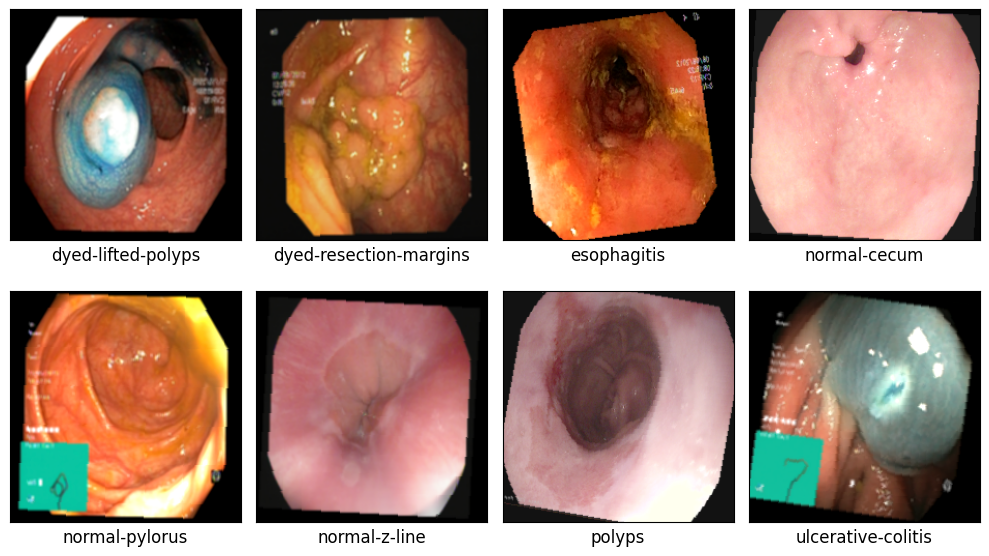

In [ ]:
visualize_data(transform, classes)

In [ ]:
BATCH_SIZE = 32
# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = create_model('vgg19', pretrained=True, num_classes=num_classes).to(device)

In [ ]:
# Print summary
summary(model, input_size=(BATCH_SIZE, 3, img_size, img_size))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 8]                   --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       73,856
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       147,584
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]         29

In [ ]:
class ClassBalancedLoss(nn.Module):
    def __init__(self, beta, num_classes):
        super().__init__()
        self.beta        = beta
        self.num_classes = num_classes

    def forward(self, logits, labels):
        counts        = np.bincount(labels.cpu().numpy(), minlength=self.num_classes)
        effective_num = 1.0 - np.power(self.beta, counts)
        weights       = (1.0 - self.beta) / (effective_num + 1e-8)
        weights       = weights / np.sum(weights)
        w             = torch.tensor(weights, dtype=torch.float32, device=logits.device)
        return nn.CrossEntropyLoss(weight=w)(logits, labels)

In [ ]:
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
train_loss_meter = MeanMetric().to(device)
# Instantiate Accuracy with the task and number of classes
train_acc_meter  = Accuracy(task='multiclass', num_classes=num_classes).to(device)
# Instantiate Accuracy with the task and number of classes
val_loss_meter   = MeanMetric().to(device)
val_acc_meter    = Accuracy(task='multiclass', num_classes=num_classes).to(device)

In [ ]:
#  a function for training one epoch
def train_one_epoch(model, train_dataloader):
  # Prepare for storing loss and accuracy
  losses = MeanMetric().to(device)
  acc = Accuracy(task='multiclass', num_classes=num_classes).to(device)
  model.train()
  # Move the model to the correct device
  model.to(device)
  for X, Y in train_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    optimizer.zero_grad()
    preds = model(X)
    loss = criteria(preds, Y)
    loss.backward()
    optimizer.step()
    preds = preds.argmax(dim=1)
    losses.update(loss, X.size(0))
    acc.update(preds, Y)

  # return loss and accuracy for the epoch
  return losses.compute().item(), acc.compute().item()

In [ ]:
# a function for validation one epoch
def validation_one_epoch(model, val_dataloader):
  losses = MeanMetric().to(device)
  acc = Accuracy(task='multiclass', num_classes=num_classes).to(device)
  model.eval()
  model.to(device)
  for X, Y in val_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    preds = model(X)
    loss = criteria(preds, Y)
    preds = preds.argmax(dim=1)
    losses.update(loss, X.size(0))
    acc.update(preds, Y)

  return losses.compute().item(), acc.compute().item()

In [ ]:
history = pd.DataFrame()
epochs = 20

In [ ]:
for i in range(0, epochs):
  # train one epoch
  train_loss, train_acc = train_one_epoch(model, train_loader)
  # validation one epoch
  val_loss, val_acc = validation_one_epoch(model, val_loader)
  # store and print loss and accuracy per epoch
  statistics = pd.DataFrame({
  "epoch": [i], "train_loss": [train_loss],
  "train_acc": [train_acc],
  "val_loss": [val_loss],
  "val_acc": [val_acc]})
  history = pd.concat([history, statistics], ignore_index=True)
  print(statistics.to_dict(orient="records")[0])

{'epoch': 0, 'train_loss': 1.3855233192443848, 'train_acc': 0.5346428751945496, 'val_loss': 0.5901703834533691, 'val_acc': 0.7941176295280457}
{'epoch': 1, 'train_loss': 0.5621817708015442, 'train_acc': 0.772857129573822, 'val_loss': 0.4936501383781433, 'val_acc': 0.7990196347236633}
{'epoch': 2, 'train_loss': 0.43081343173980713, 'train_acc': 0.824999988079071, 'val_loss': 0.6485788226127625, 'val_acc': 0.7647058963775635}
{'epoch': 3, 'train_loss': 0.3858701288700104, 'train_acc': 0.8371428847312927, 'val_loss': 0.34034451842308044, 'val_acc': 0.8651960492134094}
{'epoch': 4, 'train_loss': 0.32878541946411133, 'train_acc': 0.8632143139839172, 'val_loss': 0.33242711424827576, 'val_acc': 0.8578431606292725}
{'epoch': 5, 'train_loss': 0.303378164768219, 'train_acc': 0.8778571486473083, 'val_loss': 0.3536638617515564, 'val_acc': 0.8578431606292725}
{'epoch': 6, 'train_loss': 0.2778635323047638, 'train_acc': 0.8846428394317627, 'val_loss': 0.37906065583229065, 'val_acc': 0.857843160629272

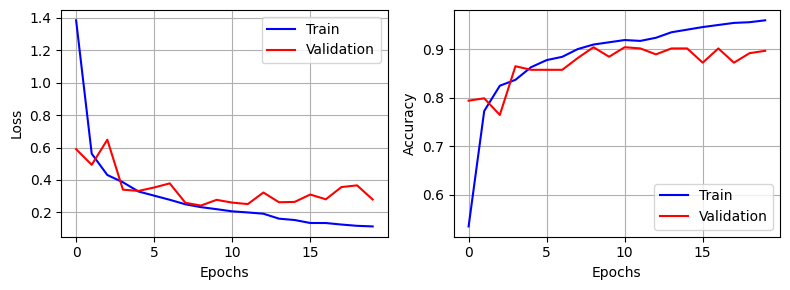

In [ ]:
# Create a figure with two subplots (side by side)
plt.figure(figsize=(8, 3))
# Plot Loss Curve (Train + Validation)
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(history["epoch"], history["train_loss"], label="Train",
color="blue")
plt.plot(history["epoch"], history["val_loss"], label="Validation",
color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
# Plot Accuracy Curve (Train + Validation)
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(history["epoch"], history["train_acc"], label="Train",
color="blue")
plt.plot(history["epoch"], history["val_acc"], label="Validation",
color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [ ]:
# prepare for storing evaluation metrics
test_acc = Accuracy(task='multiclass', num_classes=num_classes).to(device)
test_confusion_matrix=ConfusionMatrix(task="multiclass",
num_classes=num_classes).to(device)
test_precision = Precision(task="multiclass", num_classes=num_classes,
average="macro").to(device)
test_recall = Recall(task="multiclass", num_classes=num_classes,
average="macro").to(device)
test_f1_score = F1Score(task="multiclass", num_classes=num_classes,
average="macro").to(device)
model = model.to(device)
model.eval() # set model to evaluation mode
with torch.no_grad():
  for X, Y in test_loader:
    X = X.to(device)
    Y = Y.to(device)
    preds = model(X) # model forward
    preds = preds.argmax(dim=1) # obtain the final predicted class
    # store loss and accuracy per batc
    test_confusion_matrix.update(preds, Y)
    test_acc.update(preds, Y)
    test_precision.update(preds, Y)
    test_recall.update(preds, Y)
    test_f1_score.update(preds, Y)
  # Print the results
  print("Confusion Matrix:\n", test_confusion_matrix.compute())
  print("Accuracy:", test_acc.compute().item())
  print("Precision:", test_precision.compute().item())
  print("Recall:", test_recall.compute().item())
  print("F1 Score:", test_f1_score.compute().item())

Confusion Matrix:
 tensor([[ 90,  17,   0,   1,   0,   0,   1,   0],
        [ 11,  99,   0,   1,   0,   0,   0,   0],
        [  0,   0, 112,   0,   0,   2,   0,   0],
        [  0,   0,   0,  91,   0,   0,   1,   2],
        [  0,   0,   0,   0,  92,   0,   0,   0],
        [  0,   0,  29,   0,   1,  55,   2,   2],
        [  0,   0,   0,   6,   2,   0,  79,   3],
        [  0,   0,   0,   2,   0,   0,   2,  89]], device='cuda:0')
Accuracy: 0.8926767706871033
Precision: 0.9037102460861206
Recall: 0.8901082277297974
F1 Score: 0.8903990387916565


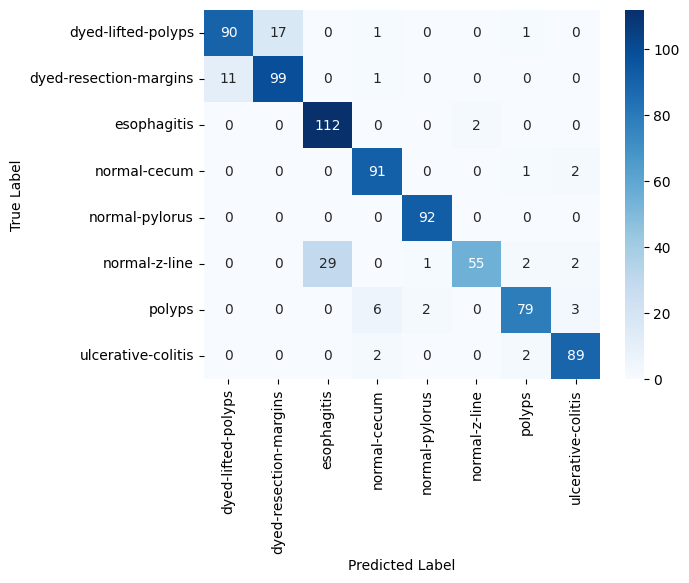

In [ ]:
# Create a heatmap for better confusion matrix visualization
sns.heatmap(test_confusion_matrix.compute().cpu(), annot=True, fmt="d",
cmap="Blues", xticklabels=classes, yticklabels=classes)
# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

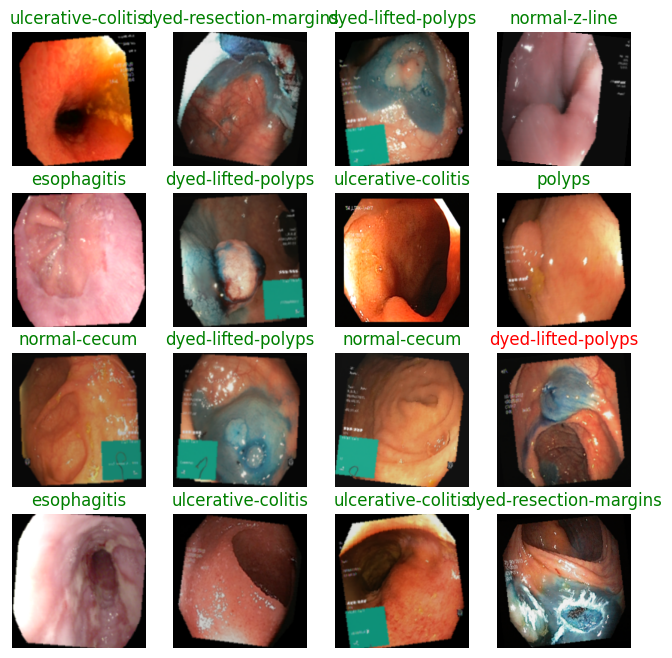

In [ ]:
# Define denormalization transform
def denormalize(tensor):
  # Reshape to match image dimensions
  mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
  return tensor * std + mean # Reverse normalization
# shuffle the test data to have samples from all classes
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
shuffle=True)
# obtain one batch of test images
images, labels = next(iter(test_dataloader))
# move model to cpu
model = model.to('cpu')
# get sample outputs
model.eval()
with torch.no_grad():
  preds = model(images) # model forward
  preds = preds.argmax(dim=1) # obtain the final predicted class
# Create a 4x4 grid for displaying the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
# Iterate over the images and display them in the grid
for idx, ax in enumerate(axes.flat):
  image = images[idx] # get one image
  image = denormalize(image) # denormalize
  # convert back to PIL image format
  image = to_pil_image(image.clamp(0, 1))
  ax.imshow(image) # Display the image
  ax.axis('off') # Hide the axes
  # Add title to the image
  # green: correct prediciton, red: incorrect prediction
  ax.set_title("{}".format(classes[preds[idx]]),
  color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/DL_Assignment/model.pth'

In [ ]:
torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
# !pip install streamlit torch torchvision timm pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 900.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [ ]:
# !pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.6 MB/s eta 0:00:00


In [ ]:
# Streamlit sidebar for model path customization
st.sidebar.header("Settings")
model_path = st.sidebar.text_input(
    label="Path to model weights (including .pth file)",
    value=MODEL_PATH,
    help="Absolute path to your model .pth file"
)

NameError: name 'st' is not defined

In [ ]:
%%bash
cat << 'EOF' > app.py
import streamlit as st
import torch
from PIL import Image
import timm
import os
import warnings
import torchvision.transforms.v2 as v2

# ---------------------------
# Gastrointestinal Tract Image Classifier App
# ---------------------------

# Suppress Streamlit warnings in bare mode
warnings.filterwarnings(
    "ignore",
    message="Thread '.*': missing ScriptRunContext! This warning can be ignored when running in bare mode\\."
)

# Default model weights path (can be overridden via sidebar)
DEFAULT_MODEL_PATH = '/content/drive/MyDrive/DL_Assignment/model.pth'

# Streamlit sidebar for settings
st.sidebar.header("Settings")
model_path = st.sidebar.text_input(
    label="Path to model weights (including .pth file)",
    value=DEFAULT_MODEL_PATH,
    help="Absolute or relative path to your trained model weights"
)

# Define the 8 GI tract classes
class_names = [
    'dyed-lifted-polyps',
    'dyed-resection-margins',
    'esophagitis',
    'normal-cecum',
    'normal-pylorus',
    'normal-z-line',
    'polyps',
    'ulcerative-colitis'
]

@st.cache_resource
# Load and cache the model
def load_model(path):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Instantiate the same architecture used during training
    model = timm.create_model('vgg19', pretrained=False, num_classes=len(class_names))

    # If user provided a directory, append 'model.pth'
    if os.path.isdir(path):
        path = os.path.join(path, 'model.pth')

    # Verify that the file exists
    if not os.path.isfile(path):
        st.error(f"Model weights not found at: {path}")
        st.stop()

    # Load state dict
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    return model, device

# Load model using sidebar value
model, device = load_model(model_path)

# Preprocessing pipeline using torchvision.transforms.v2
img_size = 224
preprocess = v2.Compose([
    v2.Resize((img_size, img_size)),
    v2.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 2.0)),  # Denoise
    v2.RandomHorizontalFlip(p=0.5),                       # Augmentation
    v2.RandomRotation(degrees=10),                        # Augmentation
    v2.ColorJitter(brightness=0.2, contrast=0.2),         # Augmentation
    v2.ToTensor(),                                        # Convert to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406],              # Normalize
                 std=[0.229, 0.224, 0.225])
])

# Streamlit UI layout
st.title("Gastrointestinal Tract Image Classifier")
st.write("Upload an endoscopic image and receive a prediction for one of eight GI tract classes.")

# File uploader component
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])
if uploaded_file is not None:
    # Open and display the image
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Preprocess and run inference
    input_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
        pred_idx = outputs.argmax(dim=1).item()
        pred_class = class_names[pred_idx]

    # Display the predicted class
    st.success(f"Predicted Class: **{pred_class}**")
EOF

In [ ]:
!pip install pyngrok

In [ ]:
!ngrok authtoken YOUR_AUTHTOKEN

In [ ]:
!ngrok config check


In [ ]:
ngrok http http://localhost:8501

In [ ]:
!streamlit run app.py

In [ ]:
from pyngrok import ngrok
# Replace 'YOUR_AUTHTOKEN' with your actual ngrok authtoken from your ngrok dashboard
!ngrok authtoken 2xEiPaPDjFRPehV92iLnc8QmqEd_7fohiHrMtFegD8joRpJkG
!streamlit run app.py &
public_url = ngrok.connect(8501)
print("🔗 Your app is live on:", public_url)
print("🔗 Your app is live on:", public_url)